In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import torch
from torch import nn
from torch import optim
import os
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def carregar_dadosv2(train_data, test_data, test_size=0.2, random_state=42):
    # Load data from CSV file
    train_data = pd.read_csv(train_data)
    val_data = pd.read_csv(test_data)

    # Split data into features (X) and targets (y) ("hysteresis")
    X = train_data.drop(['hysteresis', 'joule'], axis=1)
    y = train_data[['hysteresis', 'joule']]

    # Perform train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_test = val_data.drop(['hysteresis', 'joule'], axis=1)
    y_test = val_data[['hysteresis', 'joule']]

    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_comparacao(y_true, y_pred):
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()

    plt.figure(figsize=(8, 6))

    plt.scatter(y_true, y_pred, color='blue', alpha=0.5)

    max_val = max(y_true.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Linha de Referência')

    plt.xlabel('Valores previstos')
    plt.ylabel('valores Reais')
    plt.title('Comparação entre Valores Reais e Valores Previstos')
    plt.legend()


    plt.show()


import matplotlib.pyplot as plt

In [ ]:
class threeNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(threeNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
!pip install torchmetrics

In [ ]:
from torch import tensor
from torchmetrics.regression import MeanAbsolutePercentageError
from sklearn.metrics import mean_squared_error, mean_absolute_error
def load_model(filename, model_class, input_size, output_size):
    print("Carregando modelo...")
    checkpoint = torch.load(filename)

    model = model_class(input_size, output_size)

    model.load_state_dict(checkpoint['state_dict'])

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    optimizer.load_state_dict(checkpoint['optimizer'])

    return model, optimizer

def save_model(state,filename="Saved_Model.pth"):
  print("salvando modelo...")
  torch.save(state,filename)

def train(model,num_epochs,optimizer,train_set,target,val_set,val_target):
  criterion = nn.L1Loss()
  for epoch in range(num_epochs):
      optimizer.zero_grad()
      outputs = model(train_set)
      loss = criterion(outputs, target)
      loss.backward()
      optimizer.step()

      if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

      model.eval()  # Set the model to evaluation mode
      with torch.no_grad():  # Disable gradient calculation for validation
          val_outputs = model(val_set)
          val_loss = criterion(val_outputs, val_target)
          if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Val_Loss: {val_loss}')

def test(model,data):
  model.eval()
  criterion_MSE = nn.MSELoss()
  criterion_MAE = nn.L1Loss()
  criterion_MAPE = MeanAbsolutePercentageError()
  with torch.no_grad():
      predicted = model(data[0])
      test_loss_MSE = criterion_MSE(predicted, data[1])
      test_loss_MAE = criterion_MAE(predicted, data[1])
      test_loss_MAPE = criterion_MAPE(predicted, data[1])
      print(f'MSE Test Loss: {test_loss_MSE.item():.4f}')
      print(f'MAE Test Loss: {test_loss_MAE.item():.4f}')
      print(f'MAPE Test Loss: {test_loss_MAPE.item():.4f}')
  return predicted

In [ ]:
folder_path = '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs/2D'
os.chdir(folder_path)

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = carregar_dadosv2('dados_de_treino.csv','dados_de_teste.csv')


Separando os "targets"

In [ ]:
histeresis_train_tensor = [pair[0].item() for pair in y_train_tensor]
histeresis_train_tensor = torch.tensor(histeresis_train_tensor, dtype=torch.float32)
histeresis_train_tensor = histeresis_train_tensor.unsqueeze(1)

joule_train_tensor = [pair[1].item() for pair in y_train_tensor]
joule_train_tensor = torch.tensor(joule_train_tensor, dtype=torch.float32)
joule_train_tensor = joule_train_tensor.unsqueeze(1)

histeresis_val_tensor = [pair[0].item() for pair in y_val_tensor]
histeresis_val_tensor = torch.tensor(histeresis_val_tensor, dtype=torch.float32)
histeresis_val_tensor = histeresis_val_tensor.unsqueeze(1)

joule_val_tensor = [pair[1].item() for pair in y_val_tensor]
joule_val_tensor = torch.tensor(joule_val_tensor, dtype=torch.float32)
joule_val_tensor = joule_val_tensor.unsqueeze(1)

histeresis_test_tensor = [pair[0].item() for pair in y_test_tensor]
histeresis_test_tensor = torch.tensor(histeresis_test_tensor, dtype=torch.float32)
histeresis_test_tensor = histeresis_test_tensor.unsqueeze(1)

joule_test_tensor = [pair[1].item() for pair in y_test_tensor]
joule_test_tensor = torch.tensor(joule_test_tensor, dtype=torch.float32)
joule_test_tensor = joule_test_tensor.unsqueeze(1)

criando modelos para teste


In [ ]:
input_size = X_train_tensor.shape[1]
print(input_size)

model2D_hysteresis = threeNetwork(input_size, 1)
model2D_joule = threeNetwork(input_size, 1)
model2D_total = threeNetwork(input_size, 2)

optimizer_h = optim.Adam(model2D_hysteresis.parameters(), lr=0.001)
optimizer_j = optim.Adam(model2D_joule.parameters(), lr=0.001)
optimizer_t = optim.Adam(model2D_total.parameters(), lr=0.001)

14


Testes para "histeresis"

In [ ]:
train(model2D_hysteresis,10000,optimizer_h,X_train_tensor, histeresis_train_tensor,X_val_tensor,histeresis_val_tensor)

Epoch [100/10000], Loss: 0.2465
Epoch [100/10000], Val_Loss: 0.2443847358226776
Epoch [200/10000], Loss: 0.0900
Epoch [200/10000], Val_Loss: 0.0870165079832077
Epoch [300/10000], Loss: 0.0606
Epoch [300/10000], Val_Loss: 0.060149285942316055
Epoch [400/10000], Loss: 0.0493
Epoch [400/10000], Val_Loss: 0.04929232597351074
Epoch [500/10000], Loss: 0.0410
Epoch [500/10000], Val_Loss: 0.041810981929302216
Epoch [600/10000], Loss: 0.0362
Epoch [600/10000], Val_Loss: 0.037112537771463394
Epoch [700/10000], Loss: 0.0332
Epoch [700/10000], Val_Loss: 0.034120820462703705
Epoch [800/10000], Loss: 0.0304
Epoch [800/10000], Val_Loss: 0.03135080263018608
Epoch [900/10000], Loss: 0.0288
Epoch [900/10000], Val_Loss: 0.02973596379160881
Epoch [1000/10000], Loss: 0.0277
Epoch [1000/10000], Val_Loss: 0.02872399426996708
Epoch [1100/10000], Loss: 0.0268
Epoch [1100/10000], Val_Loss: 0.02759205549955368
Epoch [1200/10000], Loss: 0.0260
Epoch [1200/10000], Val_Loss: 0.0268511101603508
Epoch [1300/10000], L

In [ ]:
train(model2D_joule,10000,optimizer_j,X_train_tensor, joule_train_tensor,X_val_tensor,joule_val_tensor)

Epoch [100/10000], Loss: 0.2266
Epoch [100/10000], Val_Loss: 0.2205672562122345
Epoch [200/10000], Loss: 0.1029
Epoch [200/10000], Val_Loss: 0.10013929754495621
Epoch [300/10000], Loss: 0.0828
Epoch [300/10000], Val_Loss: 0.0816853865981102
Epoch [400/10000], Loss: 0.0628
Epoch [400/10000], Val_Loss: 0.06217294558882713
Epoch [500/10000], Loss: 0.0456
Epoch [500/10000], Val_Loss: 0.04576180875301361
Epoch [600/10000], Loss: 0.0378
Epoch [600/10000], Val_Loss: 0.03863988444209099
Epoch [700/10000], Loss: 0.0336
Epoch [700/10000], Val_Loss: 0.034592971205711365
Epoch [800/10000], Loss: 0.0313
Epoch [800/10000], Val_Loss: 0.03243868798017502
Epoch [900/10000], Loss: 0.0298
Epoch [900/10000], Val_Loss: 0.03101656399667263
Epoch [1000/10000], Loss: 0.0286
Epoch [1000/10000], Val_Loss: 0.029995953664183617
Epoch [1100/10000], Loss: 0.0277
Epoch [1100/10000], Val_Loss: 0.029203932732343674
Epoch [1200/10000], Loss: 0.0271
Epoch [1200/10000], Val_Loss: 0.028563031926751137
Epoch [1300/10000], 

In [ ]:
train(model2D_total,10000,optimizer_t,X_train_tensor, y_train_tensor,X_val_tensor,y_val_tensor)

Epoch [100/10000], Loss: 0.2100
Epoch [100/10000], Val_Loss: 0.2059156745672226
Epoch [200/10000], Loss: 0.1167
Epoch [200/10000], Val_Loss: 0.11276774108409882
Epoch [300/10000], Loss: 0.0694
Epoch [300/10000], Val_Loss: 0.06740552932024002
Epoch [400/10000], Loss: 0.0522
Epoch [400/10000], Val_Loss: 0.05178004503250122
Epoch [500/10000], Loss: 0.0435
Epoch [500/10000], Val_Loss: 0.04365698993206024
Epoch [600/10000], Loss: 0.0385
Epoch [600/10000], Val_Loss: 0.03893621265888214
Epoch [700/10000], Loss: 0.0352
Epoch [700/10000], Val_Loss: 0.03592660650610924
Epoch [800/10000], Loss: 0.0329
Epoch [800/10000], Val_Loss: 0.033846501260995865
Epoch [900/10000], Loss: 0.0312
Epoch [900/10000], Val_Loss: 0.03204323351383209
Epoch [1000/10000], Loss: 0.0299
Epoch [1000/10000], Val_Loss: 0.03081432171165943
Epoch [1100/10000], Loss: 0.0291
Epoch [1100/10000], Val_Loss: 0.030109645798802376
Epoch [1200/10000], Loss: 0.0284
Epoch [1200/10000], Val_Loss: 0.02958448976278305
Epoch [1300/10000], L

In [ ]:
previstos_h = test(model2D_hysteresis,[X_test_tensor,histeresis_test_tensor])

MSE Test Loss: 0.0178
MAE Test Loss: 0.0221
MAPE Test Loss: 0.1004


In [ ]:
previstos_j = test(model2D_joule,[X_test_tensor,joule_test_tensor])

MSE Test Loss: 0.1892
MAE Test Loss: 0.0271
MAPE Test Loss: 0.1232


In [ ]:
previstos_t = test(model2D_total,[X_test_tensor,y_test_tensor])

MSE Test Loss: 0.1039
MAE Test Loss: 0.0270
MAPE Test Loss: 0.1234


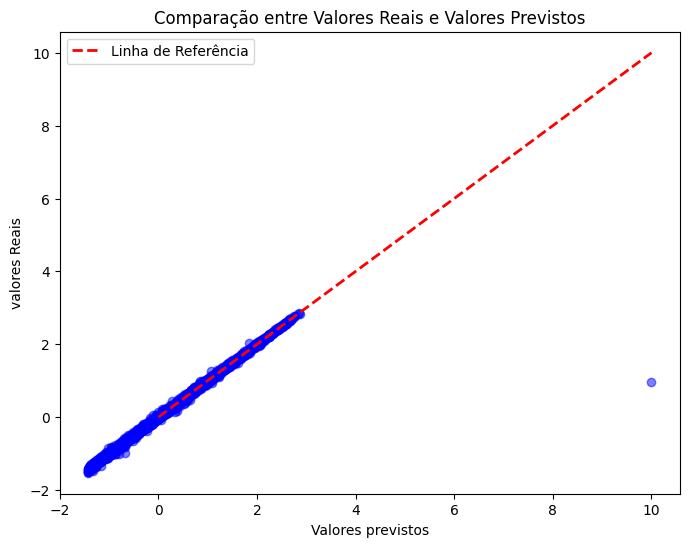

In [ ]:
plot_comparacao(histeresis_test_tensor,previstos_h)

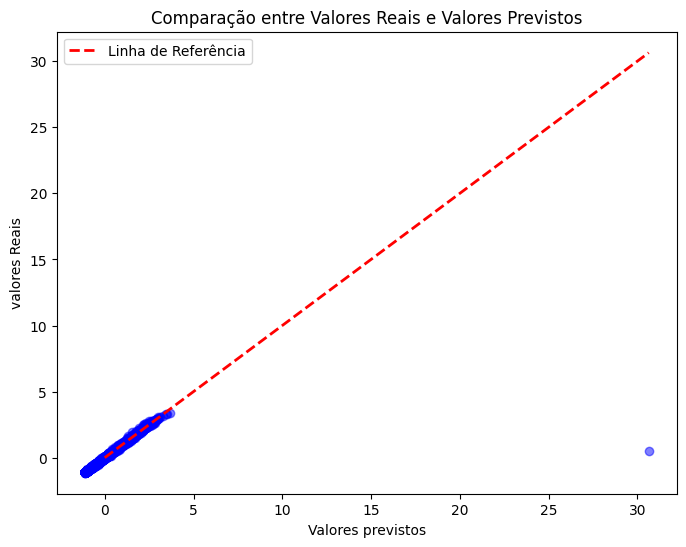

In [ ]:
plot_comparacao(joule_test_tensor,previstos_j)

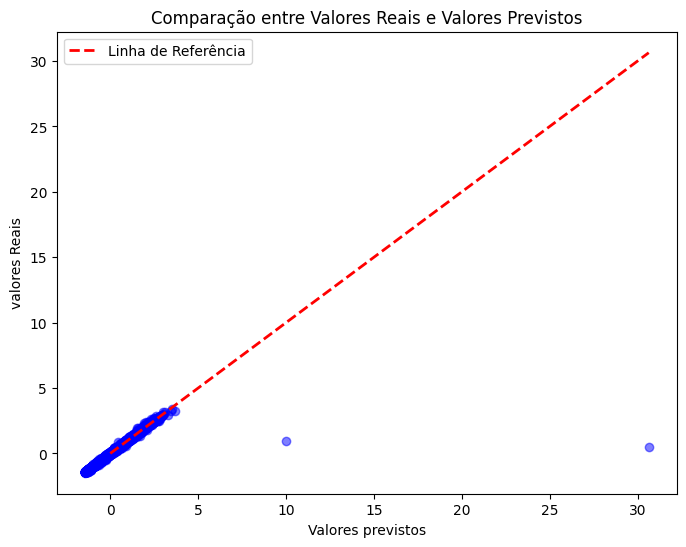

In [ ]:
plot_comparacao(y_test_tensor,previstos_t)

In [ ]:
mse_h = mean_squared_error(histeresis_test_tensor, previstos_h)
mae_h = mean_absolute_error(histeresis_test_tensor, previstos_h)
histeresis_test_np = histeresis_test_tensor.numpy()
previstos_np_h = previstos_h.numpy()
mape_h = np.mean(np.abs((histeresis_test_np - previstos_np_h) / histeresis_test_np)) * 100

mse_j = mean_squared_error(joule_test_tensor, previstos_j)
mae_j = mean_absolute_error(joule_test_tensor, previstos_j)
joule_test_np = joule_test_tensor.numpy()
previstos_np_j = previstos_j.numpy()
mape_j = np.mean(np.abs((joule_test_np - previstos_np_j) / joule_test_np)) * 100

mse_t = mean_squared_error(y_test_tensor, previstos_t)
mae_t = mean_absolute_error(y_test_tensor, previstos_t)
total_test_np = y_test_tensor.numpy()
previstos_np_t = previstos_t.numpy()
mape_t = np.mean(np.abs((total_test_np - previstos_np_t) / total_test_np)) * 100

print(f'2D histeresis model:')
print(f'Test MSE: {mse_h}')
print(f'Test MAE: {mae_h}')
print(f'Test MAPE: {mape_h}%')

print(f'2D joule model:')
print(f'Test MSE: {mse_j}')
print(f'Test MAE: {mae_j}')
print(f'Test MAPE: {mape_j}%')

print(f'2D total model:')
print(f'Test MSE: {mse_t}')
print(f'Test MAE: {mae_t}')
print(f'Test MAPE: {mape_t}%')

2D histeresis model:
Test MSE: 0.01781507395207882
Test MAE: 0.022053586319088936
Test MAPE: 10.0428506731987%
2D joule model:
Test MSE: 0.18923303484916687
Test MAE: 0.027115680277347565
Test MAPE: 12.32423484325409%
2D total model:
Test MSE: 0.10393586754798889
Test MAE: 0.027006033807992935
Test MAPE: 12.344862520694733%
